# Analysis of the _Sampson's Monks_ dataset

In [1]:
from pathlib import Path
import random
import numpy as np
import pandas as pd
import igraph as ig
import networkx as nx
import matplotlib as mpl
import matplotlib.patheffects as pe
import matplotlib.pyplot as plt
import seaborn as sns
from msb import Balance
from msb.utils import frustration_count, label_clusters

#%matplotlib inline
sns.set_theme(
    context="notebook",
    style="whitegrid",
    font_scale=1.3,
    palette="deep"
)

COLORS = np.array(["#c76674", "#9a9945", "#8961b3"])
RED    = "#f97959"
BLUE   = "#60a1f7"
GRAY   = "#efefef"
GROUPS = ("Loyal Opposition", "Young Turks", "Outcasts")
CMAP   = dict(zip(GROUPS, COLORS))

# Paths
ROOT = Path(".").absolute().parent
DATA = ROOT/"data"/"sampson"
FIGS = ROOT/"figs"
FIGS.mkdir(exist_ok=True)

# Get network datasets
ALL_NETWORKS = tuple(
    ig.Graph.Read_GraphMLz(str(DATA/f"t{i}.graphml.gz"))
    for i in range(1, 6)
)

# Networks for specific timesteps
G1, G2, G3, G4, G5 = ALL_NETWORKS
NETWORKS = G2, G3, G4
for G in NETWORKS: G["t"] = int(G["t"])
# NETWORKS = G1, G4, G5
N_NET = len(NETWORKS)

# Balance params
BKWS = dict(m=None, kmin=2)


/home/sztal/miniconda3/envs/msb/lib/python3.10/site-packages/igraph/io/files.py:189: RuntimeWarning: Could not add vertex ids, there is already an 'id' vertex attribute. at src/io/graphml.c:492
  return cls.Read_GraphML(tmpfile, index=index)


## Build-up of the conflict

### Network clusters

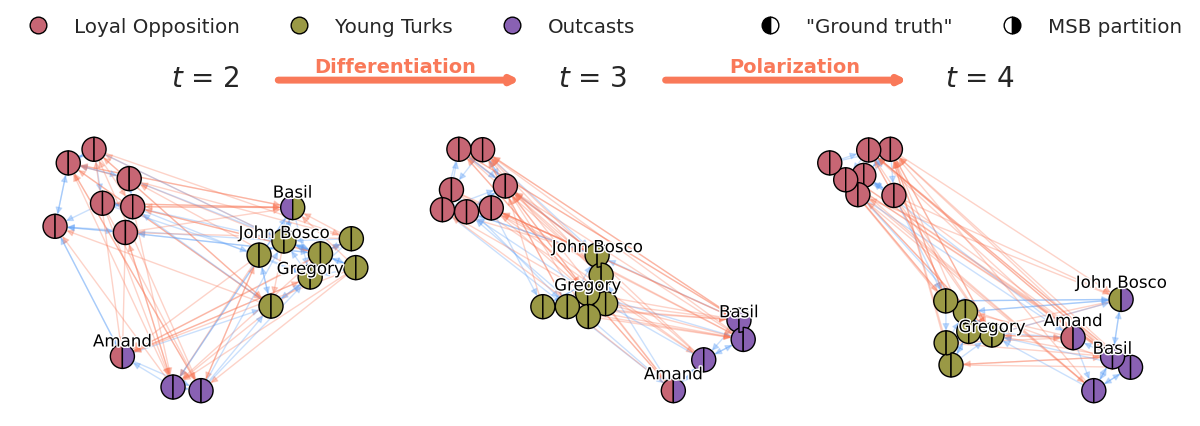

In [2]:
import random
random.seed(303)

FOCAL = ("John Bosco", "Basil", "Amand", "Gregory")

fig, axes = plt.subplots(ncols=N_NET, figsize=(4*N_NET, 4))

for G, ax in zip(NETWORKS, axes):
    t = G["t"]
    B = Balance(G, **BKWS)
    fidx, hc = B.find_clusters()
    names = np.array(G.vs["name"])
    group = np.array(G.vs["faction"])
    clust = label_clusters(hc.labels_, group)

    Gp = G.copy()
    Gp.es.select(weight_lt=0).delete()
    weights = np.array(Gp.es["weight"])
    vc = ig.VertexClustering(Gp, membership=hc.labels_)
    Gp.es["weight"] = np.where(vc.crossing(), 5*weights, weights)
    pos = nx.kamada_kawai_layout(Gp.to_networkx())
    N = G.to_networkx()
    kwds = dict(G=N, pos=pos, ax=ax)

    ecolors = [ RED if e["weight"] < 0 else BLUE for e in N.edges.values() ]
    nx.draw_networkx_edges(**kwds, edge_color=ecolors, alpha=.33)

    x, y = np.stack(list(pos.values())).T
    ncolors = [ CMAP[f] for f in G.vs["faction"] ]
    ax.scatter(
        x, y, color=ncolors, edgecolors="black", s=300,
        marker=mpl.markers.MarkerStyle("o", fillstyle="left")
    )
    ncolors = [ CMAP[f] for f in clust ]
    ax.scatter(
        x, y, color=ncolors, edgecolors="black", s=300,
        marker=mpl.markers.MarkerStyle("o", fillstyle="right")
    )

    labels = {
        idx: n for idx, data in N.nodes(data=True)
        if (n := data["name"]) in FOCAL
    }
    for idx, name in labels.items():
        x, y = pos[idx]
        if name == "Amand" or (t == 2 and name == "Basil") \
        or (t == 4 and name == "John Bosco"):
            y += .05
        ax.text(x, y, name, size=12, color="black", path_effects=[
            pe.withStroke(linewidth=2, foreground="white")
        ], ha="center", va="bottom")

    ax.set_title(fr"$t$ = {t}", y=1.1, fontsize=20)
    ax.axis("off")

col = RED
# Add connection patch (2)
axA, axB = axes[:2]
conn = mpl.patches.ConnectionPatch(
    xyA=(.7, 1.15), coordsA=axA.transAxes,
    xyB=(.3, 1.15), coordsB=axB.transAxes,
    arrowstyle="-|>"
)
conn.set_color(col)
conn.set_in_layout(False)
conn.set_linewidth(5)
label = axA.annotate(
    "Differentiation", xy=(.8, 1.175),
    xycoords=axA.transAxes,
    weight="bold", color=col,
    fontsize=14
)
label.set_in_layout(False)
axA.add_artist(conn)
# Add connection patch (2)
axA, axB = axes[-2:]
conn = mpl.patches.ConnectionPatch(
    xyA=(.7, 1.15), coordsA=axA.transAxes,
    xyB=(.3, 1.15), coordsB=axB.transAxes,
    arrowstyle="-|>"
)
conn.set_color(col)
conn.set_in_layout(False)
conn.set_linewidth(5)
label = axA.annotate(
    "Polarization", xy=(.875, 1.175),
    xycoords=axA.transAxes,
    weight="bold", color=col,
    fontsize=14
)
label.set_in_layout(False)
axA.add_artist(conn)

handles = [
    mpl.lines.Line2D(
        [0], [0], color="black", lw=0, label=label,
        marker=mpl.markers.MarkerStyle(marker="o", fillstyle=fill),
        markersize=12
    ) for label, fill in zip(["\"Ground truth\"", "MSB partition"], ["left", "right"])
]
legend1 = fig.legend(
    handles=handles, loc="upper right", ncol=len(handles),
    frameon=False, bbox_to_anchor=(1, 1.1)
)

handles = [
    mpl.lines.Line2D(
        [0], [0], color=CMAP[g], lw=0, label=g,
        marker="o", markersize=12, markeredgecolor="black",
    ) for g in GROUPS
]
fig.legend(
    handles=handles, loc="upper left", ncol=len(GROUPS),
    frameon=False, bbox_to_anchor=(0, 1.1)
)

fig.tight_layout()
fig.savefig(FIGS/"monks-networks.pdf", bbox_inches="tight")


### Node-level measures

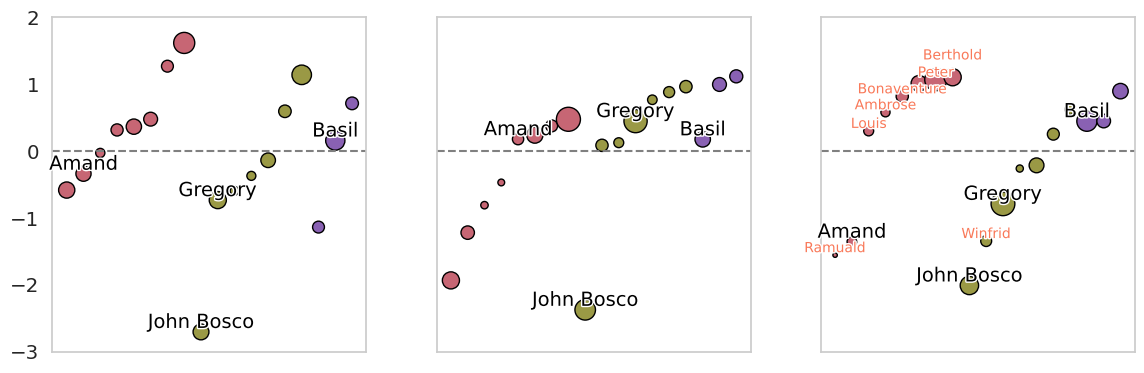

In [3]:
fig, axes = plt.subplots(ncols=N_NET, nrows=1, figsize=(4*N_NET, 4))

for G, ax in zip(NETWORKS, axes):
    t = G["t"]
    B = Balance(G, **BKWS)

    ldob = B.node_balance(beta=B.beta.max(), weak=True).set_axis(G.vs["name"])
    lctr = B.node_contrib(beta=B.beta.max()).set_axis(G.vs["name"])

    sd = ldob.std()
    z  = (ldob - ldob.mean()) / sd
    z  = pd.DataFrame({
        "faction": G.vs["faction"],
        "name": G.vs["name"],
        "z": z.reset_index(drop=True),
        "c": lctr.reset_index(drop=True)
    }) \
        .sort_values(by=["faction", "z"], ascending=True) \
        .set_index(["faction", "name"]) \
        .loc[list(GROUPS)] \
        .assign(idx=lambda df: np.arange(len(df)))

    ax.axhline(0, ls="--", color="gray")
    ax.set_ylim(-3, 2)

    gdf = z.groupby("faction")
    for group in GROUPS:
        df = gdf.get_group(group)
        x = df["idx"]
        y = df["z"]
        s = 2000*df["c"]
        ax.scatter(x, y, color=CMAP[group], s=s, edgecolors="black")

    for name in FOCAL:
        y, _, x = z.xs(name, level="name").to_numpy().squeeze()
        ax.text(x, y, name, size=14, color="black", path_effects=[
            pe.withStroke(linewidth=2, foreground="white")
        ], ha="center", va="bottom")

    ax.grid(False)
    ax.get_xaxis().set_visible(False)

ax = axes[-1]
for name in G5.vs["name"]:
    y, _, x = z.xs(name, level="name").to_numpy().squeeze()
    if name == "Berthold":
        y *= 1.2
    ax.text(x, y, name, size=10, color=RED, path_effects=[
        pe.withStroke(linewidth=2, foreground="white")
    ], ha="center", va="bottom")

for ax in axes[1:]:
    ax.get_yaxis().set_visible(False)

fig.tight_layout()
fig.savefig(FIGS/"monks-nodes.pdf", bbox_inches="tight")


### Time series

#### Degree of balance

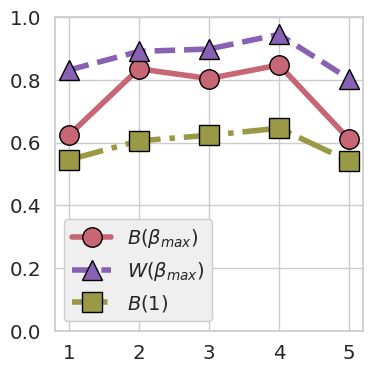

In [4]:
fig, ax = plt.subplots(figsize=(4, 4))

bobjs  = [ Balance(G, **BKWS) for G in ALL_NETWORKS ]
bobjs2 = [ Balance(G, beta=1, semi=False, **BKWS) for G in ALL_NETWORKS ]
time   = np.array([ G["t"] for G in ALL_NETWORKS ])

dobs = np.array([ b.balance(weak=False) for b in bobjs ])
labs = r"$B(\beta_{max})$"
dobw = np.array([ b.balance(weak=True) for b in bobjs ])
labw = r"$W(\beta_{max})$"
dob1 = np.array([ b.balance(weak=False) for b in bobjs2 ])
lab1 = r"$B(1)$"

# skws = dict(s=100, edgecolors="black", zorder=99)
skws = dict(markersize=14, markeredgecolor="black", zorder=99)
ax.plot(time, dobs, color=COLORS[0], lw=4, ls="-", marker="o", **skws, label=labs)
ax.plot(time, dobw, color=COLORS[2], lw=4, ls="--", marker="^", **skws, label=labw)
ax.plot(time, dob1, color=COLORS[1], lw=4, ls="-.", marker="s", **skws, label=lab1)

ax.set_ylim(0, 1)
ax.set_xticks(time)
ax.legend(facecolor=GRAY, framealpha=1, fontsize=14)

fig.tight_layout()
fig.savefig(FIGS/"monks-dob.pdf", bbox_inches="tight")


#### Frustration index

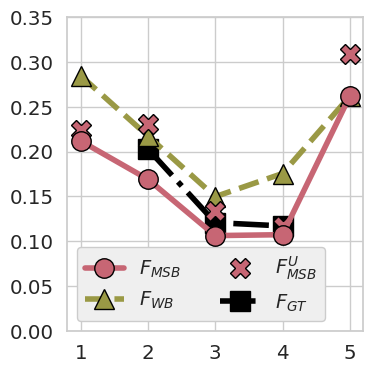

In [5]:
fig, ax = plt.subplots(figsize=(4, 4))

bobjs  = [ Balance(G, **BKWS) for G in ALL_NETWORKS ]
bobjs2 = [ Balance(G, beta=1, semi=False, **BKWS) for G in ALL_NETWORKS ]
bobjs3 = [ Balance(G, **BKWS, weighted=False) for G in ALL_NETWORKS ]
time   = np.array([ G["t"] for G in ALL_NETWORKS ])

fidx0 = np.array([
    frustration_count(Balance(G).S, G4.vs["faction"])
    if G["t"] in (2, 3, 4) else np.nan
    for G in ALL_NETWORKS
])
lab0  = r"$F_{GT}$"
fidx1 = np.array([ B.find_clusters()[0] for B in bobjs ])
lab1  = r"$F_{MSB}$"
fidx2 = np.array([ B.find_clusters()[0] for B in bobjs2 ])
lab2  = r"$F_{WB}$"
fidx3 = np.array([ B.find_clusters()[0] for B in bobjs3 ])
lab3  = r"$F^{U}_{MSB}$"

skws = dict(markersize=14, markeredgecolor="black")
ax.plot(time, fidx1, color=COLORS[0], lw=4, ls="-", marker="o", zorder=10, **skws, label=lab1)
ax.plot(time, fidx2, color=COLORS[1], lw=4, ls="--", marker="^", zorder=5, **skws, label=lab2)
ax.plot(time, fidx3, color=COLORS[0], ls="None", marker="X", zorder=9, **skws, label=lab3)
ax.plot(time, fidx0, color="black", lw=4, ls="-.", marker="s", zorder=1, **skws, label=lab0)

ax.set_ylim(0, .35)
ax.set_xticks(time)
ax.legend(facecolor=GRAY, framealpha=1, fontsize=14, ncols=2)

fig.tight_layout()
fig.savefig(FIGS/"monks-frustration.pdf", bbox_inches="tight")
